## Spectral Results Inspection

This notebook compares measurements performed on CSP spectra by different team members.

In [1]:
import sys
sys.path.insert(0, '..')


In [2]:
from pathlib import Path

import numpy as np
import yaml
from bokeh.io import output_notebook
from bokeh.layouts import gridplot
from bokeh.models import HoverTool, Range1d, Span
from bokeh.plotting import ColumnDataSource, figure, show
from matplotlib import pyplot as plt
import scipy.stats as stats
from sndata.csp import DR1
from sndata.sdss import Sako18Spec

from utils import read_in_pipeline_result


from scripts.run_csp import pre_process
from spec_analysis.spectra import Spectrum


In [3]:
output_notebook()
DR1().download_module_data()


Loading BokehJS ...

## Reading In Data


In [31]:
results_dir = Path('.').resolve().parent / 'results'

# Load config values used when analyzing the spectra
config_path = Path('../app_config.yml')
with config_path.open() as config_file:
    config_data = yaml.load(config_file, Loader=yaml.SafeLoader)

# Load measurements taken by each team member
ella = read_in_pipeline_result(results_dir / 'ella_csp.csv', 'csp').set_index('time', append=True)
emily = read_in_pipeline_result(results_dir / 'emily_csp.csv', 'csp').set_index('time', append=True)
anish = read_in_pipeline_result(results_dir / 'anish_csp.csv', 'csp').set_index('time', append=True)

# Create a combined table with measurements from all researchers
combined = ella.join(emily, lsuffix='_ella', rsuffix='_emily').join(anish.add_suffix('_anish'))
combined.head()


,,,feat_start_ella,feat_end_ella,vel_ella,vel_err_ella,vel_samperr_ella,pew_ella,pew_err_ella,pew_samperr_ella,area_ella,area_err_ella,...,pew_samperr_anish,area_anish,area_err_anish,area_samperr_anish,notes_anish,phase_anish,spec_type_anish,delta_t_anish,is_peak_anish,branch_type_anish
feat_name,obj_id,time,,,,,,,,,,,,,,,,,,,,,
pW1,2006gt,2454003.75,3675.0045,3931.1794,11362.464822,0.0,61.388286,90.243099,0.0,2.423678,4.861068e-14,0.0,...,2.423678,4.861068e-14,0.0,2.164635e-15,NaN,0.24,91bg-like,0.24,True,CL
pW8,2006gt,2454003.75,7811.6466,8597.6378,11087.042599,0.0,134.524850,280.565605,0.0,13.046939,4.706342e-14,0.0,...,13.046939,4.706342e-14,0.0,3.341364e-15,NaN,0.24,91bg-like,0.24,True,CL
pW7,2006gt,2454003.75,5939.8234,6402.6848,9553.168824,0.0,16.854108,124.350094,0.0,2.493090,4.836447e-14,0.0,...,2.635295,4.817613e-14,0.0,1.334219e-15,NaN,0.24,91bg-like,0.24,True,CL
pW6,2006gt,2454003.75,5587.5829,5934.0012,9103.786649,0.0,11.243609,51.911860,0.0,1.148714,2.109637e-14,0.0,...,1.987738,2.019208e-14,0.0,9.301553e-16,NaN,0.24,91bg-like,0.24,True,CL
pW2,2006gt,2454003.75,3931.1794,4076.7333,8843.677255,0.0,444.836943,17.783829,0.0,1.678227,1.135375e-14,0.0,...,1.678227,1.135375e-14,0.0,1.228104e-15,NaN,0.24,91bg-like,0.24,True,CL


In [28]:
def percent_differnt(combined_data, percent):
    """create table with only measurements that differ from the median by >= the given percent
    
    Args:
        combined_data (DataFrame): Combined table of pew measurements
        percent           (float): Percent difference
    
    Returns:
        Table with median pwv values for SN that deviate from the medain
    """
    
    combined_data = combined_data.copy()
    pew_cols = ["pew_ella", "pew_emily", "pew_anish"]
    combined_data['pew_median'] = combined_data.loc[: , pew_cols].median(axis=1)
    
    tot_pct = percent / 100
    pct = tot_pct * combined_data.pew_median
    df = combined_data[
        (abs(combined_data.pew_ella - combined_data.pew_emily) >= pct)
        | (abs(combined_data.pew_ella - combined_data.pew_anish) >= pct)
        | (abs(combined_data.pew_emily - combined_data.pew_anish) >= pct)
    ]
    
    return df['pew_median']


In [29]:
pct_dif_table(combined, 5)


feat_name  obj_id  time      
pW6        2005kc  2453698.58     34.353390
pW4        2005kc  2453698.58    117.143914
pW6        2004ey  2453303.56      9.803429
pW2        2004ey  2453303.56      8.916625
pW5        2004ey  2453303.56     70.909024
                                    ...    
pW6        2006ax  2453816.76     11.325566
pW3        2006ax  2453816.76     70.637024
pW2        2005iq  2453698.62     17.652870
pW3        2005iq  2453698.62     78.352060
pW4        2007S   2454131.82    117.197642
Name: pew_median, Length: 96, dtype: float64

## Comparison with CSP

We compare internal pEW measurements with published values from CSP.

In [5]:
def plot_csp_pew_comparison(pipeline_data, figsize=(12, 6)):
    """Scatter plot internal pEW measurements against published CSP results
    
    Args:
        pipeline_data (DataFrame): Output data from the analysis pipeline
        figsize           (tuple): The size of the figure
    """

    # Group pEW measurements by the feature name
    group_data = pipeline_data.groupby('feat_name')

    # Get pEW measurements from DR1
    pub_frame = DR1().load_table(6).to_pandas()
    pub_frame.rename(columns={'SN': 'obj_id'}, inplace=True)
    pub_frame.set_index(['obj_id'], inplace=True)
    
    # Useful things for plotting later on
    columns = ['pW1', 'pW2', 'pW3', 'pW4', 'pW5', 'pW6', 'pW7', 'pW8', 'pew']
    axis_limits = {
        'pW1': (50, 200),
        'pW2': (0, 40),
        'pW3': (50, 200),
        'pW4': (50, 250),
        'pW5': (20, 110),
        'pW6': (0, 75),
        'pW7': (50, 160),
        'pW8': (0, 310),
    }

    fig, axes = plt.subplots(2, 4, figsize=figsize)
    for (feat_name, feat_data), axis in zip(group_data, axes.flatten()):
        data_final = feat_data.join(pub_frame)  # Combine measured and published dataframes
        nonan_frame = data_final[columns].dropna()

        # Plot measured data
        label = config_data['features'][feat_name]['feature_id']
        axis.scatter(nonan_frame['pew'], nonan_frame[feat_name], marker="x", label=label)
        
        # Plot linear fit
        slope, intercept = np.polyfit(nonan_frame['pew'], nonan_frame[feat_name], 1)
        limits = axis_limits[feat_name]
        fit_func = np.poly1d((slope, intercept))
        axis.plot(limits, fit_func(limits), label=f'{slope: .2f}x+{intercept: .2f}', color='r')

        axis.set_xlim(limits)
        axis.set_ylim(limits)
        axis.legend()

    fig.supylabel("Measured pW ($\AA$)", fontsize=12)
    fig.supxlabel("Published pW ($\AA$)", fontsize=12)
    fig.suptitle("Measured vs. Published Results for Features in CSP", fontsize=12)
    plt.tight_layout()


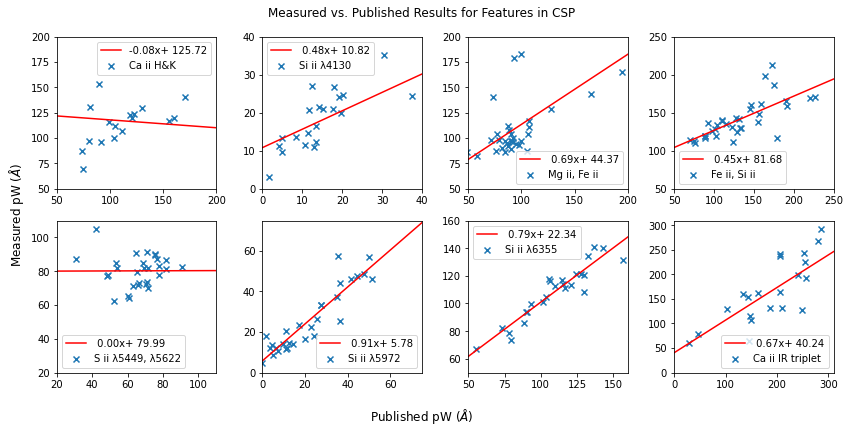

In [6]:
plot_csp_pew_comparison(anish)

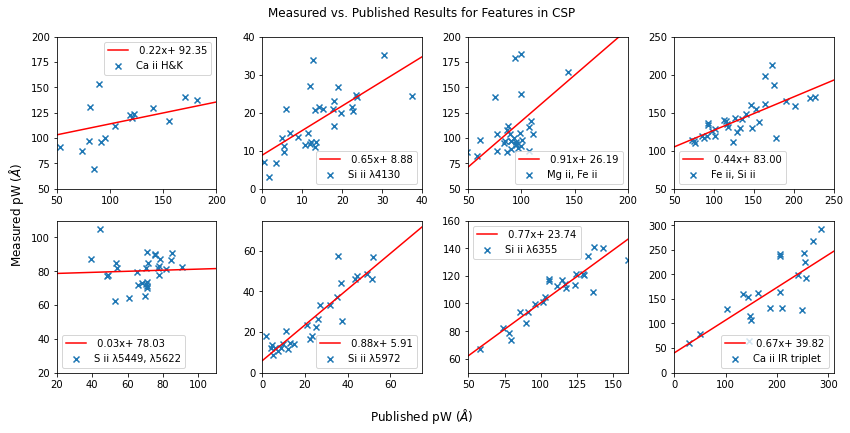

In [7]:
plot_csp_pew_comparison(emily)

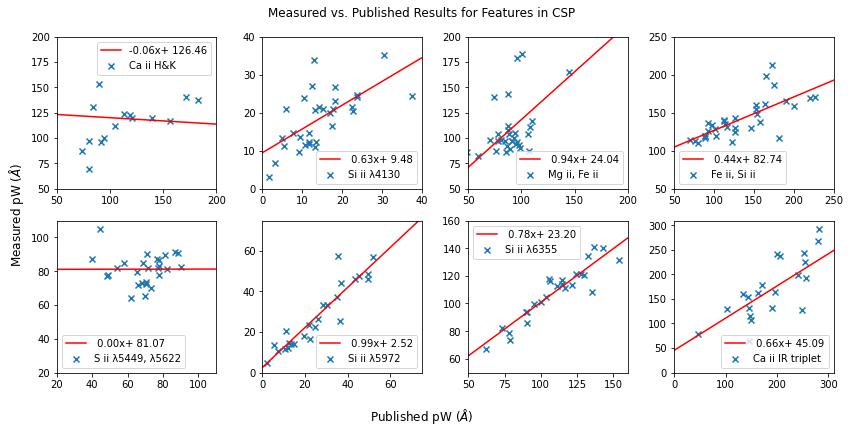

In [8]:
plot_csp_pew_comparison(ella)

## pEW Comparison Between Team Members

We compare pEW measurements between different team members.

In [9]:
def data_to_plot(set1, set2, feat):
    """Return pew values for 2 people for a given feature
    
    Parameters:
        set1 (DataFrame): first person to compare
        set2 (DataFrame): second person to compare
        feat       (str): feature name (ex. pW1)
    
    Returns:
        set1_data: list of measurements
        set2_data: list of measurements
    """

    set1 = set1.reset_index()
    set2 = set2.reset_index()
    
    if feat == 'all':
        set1_feat = set1
        set2_feat = set2
        
    else:
        # Identifying only rows with a specific feature measurement
        set1_feat = set1[set1['feat_name'] == feat]
        set2_feat = set2[set2['feat_name'] == feat]

    # Setting indices to shared values
    set1_feat2 = set1_feat.set_index(['obj_id', 'time', 'feat_name'])
    set2_feat2 = set2_feat.set_index(['obj_id', 'time', 'feat_name'])

    # Combining the two tables
    combined_table = set1_feat2.join(set2_feat2, lsuffix=f'{set1}', rsuffix=f'{set2}')

    # Dropping NaNs, i.e. rows without shared measurements
    final_table = combined_table.dropna(subset=[f'pew{set1}', f'pew{set2}'])

    # Data to be plotted
    set1_data = final_table[f'pew{set1}']
    set2_data = final_table[f'pew{set2}']
    return set1_data, set2_data


In [10]:
def bounds_finder(set1, set2, feat):
    """Find mininum and maximum for data to be plotted
    
    Parameters:
        set1 (DataFrame): first person data
        set2 (DataFrame): second person data
    
    Returns:
        The lower bound of the data
        The upper bound of the data
    """

    data1, data2 = data_to_plot(set1, set2, feat)
    min_bound = min(min(data1), min(data2))
    max_bound = max(max(data1), max(data2))
    return min_bound, max_bound


In [11]:
def compare_internal_pew(anish, ella, emily, features=None, figsize=(12, 4)):
    """plot the 3 sets of comparisons for all 8 features
    
    Args:
        anish (DataFrame): Data taken by Anish
        ella  (DataFrame): Data taken by Ella
        emily (DataFrame): Data taken by Emily
        features   (List): Optionally plot only a subset of features
        figsize   (tuple): The size of each subfigure
    """

    features = features or (f'pW{i}' for i in range(1, 9))
    for feat_name in features:

        # Used the line y=x
        x = np.arange(-60, 450)

        # Creating the figure
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize, sharey='row', sharex='row')
        fig.suptitle(f'{feat_name} Comparison')

        # Plotting the leftmost axis
        ella_fig1, emily_fig1 = data_to_plot(ella, emily, feat_name)
        min1, max1 = bounds_finder(ella, emily, feat_name)

        ax1.scatter(ella_fig1, emily_fig1)
        ax1.plot(x, x, color='black', linestyle='--')
        ax1.set_xlim(min1, max1)
        ax1.set_ylim(min1, max1)
        ax1.set_xlabel("Ella's Measurements")
        ax1.set_ylabel("Emily's Measurements")

        # Plotting the middle axis
        emily_fig2, anish_fig2 = data_to_plot(emily, anish, feat_name)
        
        ax2.scatter(emily_fig2, anish_fig2, c='green')
        ax2.plot(x, x, color='black', linestyle='--')
        ax2.set_xlabel("Emily's Measurements")
        ax2.set_ylabel("Anish's Measurements")

        # Plotting the rightmost axis
        anish_fig3, ella_fig3 = data_to_plot(anish, ella, feat_name)
        
        ax3.scatter(anish_fig3, ella_fig3, c='red')
        ax3.plot(x, x, color='black', linestyle='--')
        ax3.set_xlabel("Anish's Measurements")
        ax3.set_ylabel("Ella's Measurements")


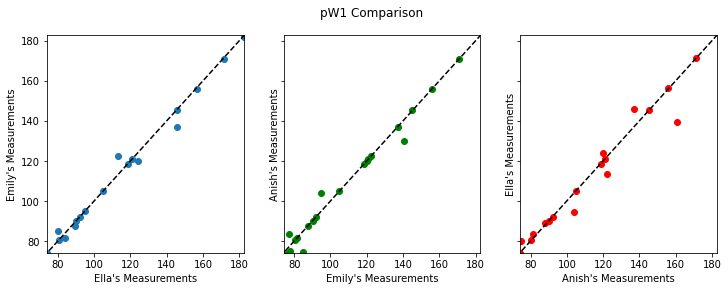

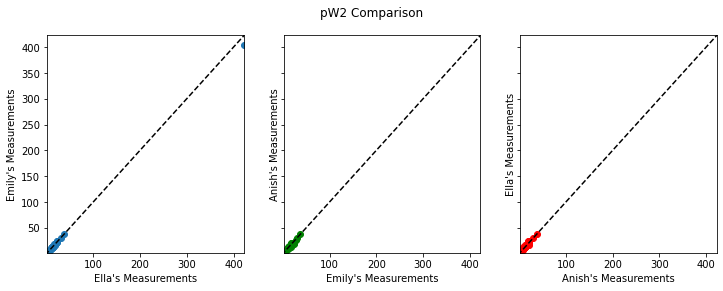

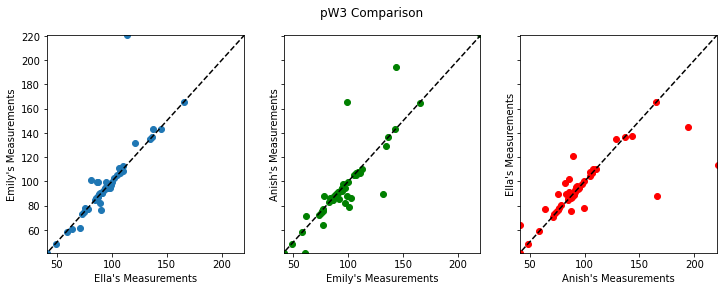

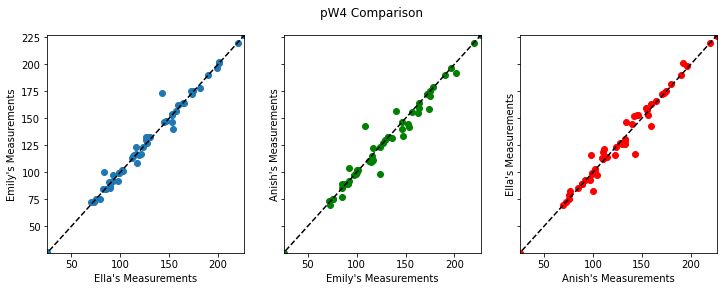

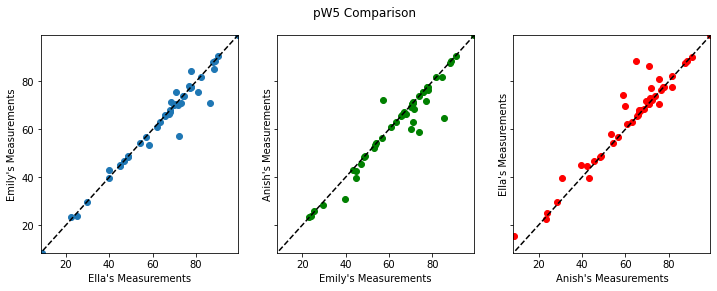

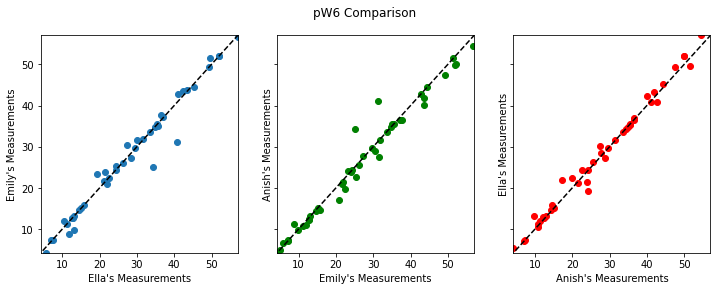

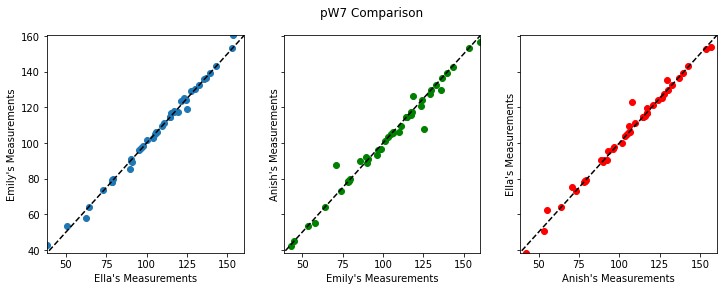

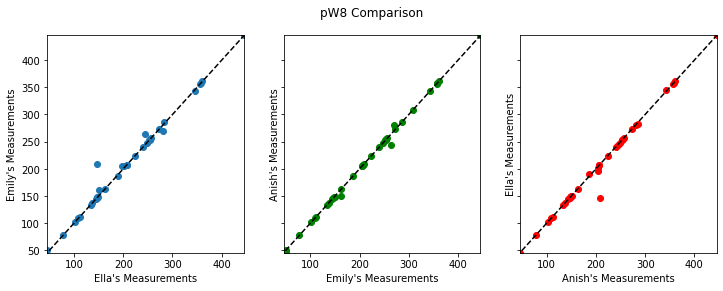

In [12]:
compare_internal_pew(anish, ella, emily)


In [13]:
def compare_all_pew_measurements(anish, ella, emily, figsize=(12, 4)):
    """Plot a comparison of pEW values for all SNe
    
    Args:
        anish (DataFrame): Data taken by Anish
        ella  (DataFrame): Data taken by Ella
        emily (DataFrame): Data taken by Emily
        figsize   (tuple): The size of each subfigure
    """

    ax1_x, ax1_y = data_to_plot(ella, emily, 'all')
    ax2_x, ax2_y = data_to_plot(emily, anish, 'all')
    ax3_x, ax3_y = data_to_plot(anish, ella, 'all')
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)
    ax1.scatter(ax1_x, ax1_y, alpha=.4)
    ax2.scatter(ax2_x, ax2_y, alpha=.4)
    ax3.scatter(ax3_x, ax3_y, alpha=.4)
    
    for ax in (ax1, ax2, ax3):
        bounds = [0, 500]
        ax.plot(bounds, bounds, color='k', linestyle='--')
        ax.set_xlim(bounds)
        ax.set_ylim(bounds)
        
    ax1.set_xlabel("Ella's Measurements")
    ax1.set_ylabel("Emily's Measurements")

    ax2.set_xlabel("Emily's Measurements")
    ax2.set_ylabel("Anish's Measurements")

    ax3.set_xlabel("Anish's Measurements")
    ax3.set_ylabel("Ella's Measurements")
    
    fig.suptitle('All pEW Measurements')
    plt.tight_layout()
    


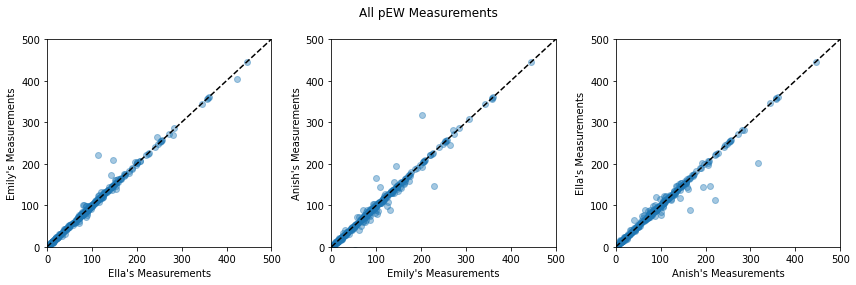

In [14]:
compare_all_pew_measurements(anish, ella, emily)


In [15]:
def plot_branch_classification_comparison(pipeline_data):
    """Create an interactive plot with branch classifications from each team member
    
    Args:
        pipeline_data (DataFrame): Combined dataframe with measurements from all team members
    """
    
    pw6 = pipeline_data.loc['pW6']
    pw7 = pipeline_data.loc['pW7']
    joined = pw6.join(pw7, lsuffix='_pw6', rsuffix='_pw7')
    source_em = ColumnDataSource(joined.reset_index())

    hover = HoverTool(
        tooltips=[
            ('index', '$index'),
            ('(x,y)', '($x, $y)'),
            ('desc', '@obj_id'),
        ]
    )

    fig = figure(plot_width=900, plot_height=800, title='pw6 vs pw7')
    fig.tools.append(hover)

    fig.circle('pew_anish_pw7', 'pew_anish_pw6', size=5, source=source_em, color='red', legend_label='Anish')
    fig.circle('pew_ella_pw7', 'pew_ella_pw6', size=5, source=source_em, color='green', legend_label='Ella')
    fig.circle('pew_emily_pw7', 'pew_emily_pw6', size=5, source=source_em, color='blue', legend_label='Emily')

    fig.legend.location = 'top_left'
    fig.legend.click_policy = 'hide'
    fig.xaxis.axis_label = 'pw7'
    fig.yaxis.axis_label = 'pw6'
    show(fig)


In [16]:
plot_branch_classification_comparison(combined)


## Feature Boundary Selection

In [17]:
def compare_boundary_selection(obj_id, time, feature, results=combined):
    """Plot an interactive comparison of estimated feature boundaries
    
    Args:
        obj_id        (str): The object to plot
        time        (float): Observation time of the desired object's spectrum
        feature       (str): Name of the feature to inspect (e.g., 'pW1')
        results (DataFrame): Dataframe of inspection results
    """

    # Load object data
    data = DR1().get_data_for_id(obj_id)
    processed_data = pre_process(data)
    processed_data = processed_data[processed_data['time'] == time]
    spectrum = Spectrum(
        processed_data['wavelength'],
        processed_data['flux'],
        processed_data.meta['ra'],
        processed_data.meta['dec'],
        processed_data.meta['z'],
    )
    spectrum.prepare_spectrum(bin_size=10)

    # Create a seperate subplot for each inspector
    sub_size = (800, 400)
    title = f'{obj_id} - {time} - {feature}'
    s1 = figure(plot_width=sub_size[0], plot_height=sub_size[1], title=title)
    s2 = figure(plot_width=sub_size[0], plot_height=sub_size[1], x_range=s1.x_range, y_range=s1.y_range)
    s3 = figure(plot_width=sub_size[0], plot_height=sub_size[1], x_range=s1.x_range, y_range=s1.y_range)

    # Instantiate plotting args
    inspectors = ('ella', 'emily', 'anish')
    obj_results = results.loc[feature, obj_id, time]
    lower_blue = config_data['features'][feature]['lower_blue']
    upper_blue = config_data['features'][feature]['upper_blue']
    lower_red = config_data['features'][feature]['lower_red']
    upper_red = config_data['features'][feature]['upper_red']

    for fig, insp in zip((s1, s2, s3), inspectors):
        # Format figure
        fig.yaxis.axis_label = insp.title()
        fig.y_range = Range1d(0, 1.1 * max(spectrum.rest_flux))

        # Plot object data and auto boundaries
        fig.line(spectrum.rest_wave, spectrum.rest_flux, alpha=0.3, color='black')
        fig.line(spectrum.rest_wave, spectrum.bin_flux, alpha=0.8, color='black')
        fig.harea([lower_blue, lower_blue], [upper_blue, upper_blue], [-1, 2], alpha=.1)
        fig.harea([lower_red, lower_red], [upper_red, upper_red], [-1, 2], alpha=.1, color='red')

        measured_start = obj_results[f'feat_start_{insp}']
        measured_end = obj_results[f'feat_end_{insp}']
        if np.isnan(measured_start):
            continue

        vline1 = Span(location=measured_start, dimension='height', line_color='red', line_width=1)
        vline2 = Span(location=measured_end, dimension='height', line_color='red', line_width=1)
        fig.renderers.extend([vline1, vline2])

    p = gridplot([[s1], [s2], [s3]])
    show(p)


In [18]:
compare_boundary_selection('2004ef', 2453255.66, 'pW2')
